In [65]:
import numpy as np
import pandas as pd
import os
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize

# 1. Load data and show basic info

In [13]:
train_df = pd.read_csv(r'..\data\processed\train_v2.csv')
print('dataset size: {}'.format(train_df.shape[0]))
train_df.head()

dataset size: 40479


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


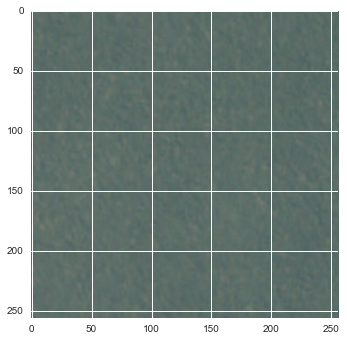

image dimensiotn((256, 256, 3))


In [14]:
train_jpg_path = r'..\data\processed\train-jpg'
image_names_sample = os.listdir(train_jpg_path)[:10]
sample_image = io.imread(os.path.join(train_jpg_path, image_names_sample[0]))
plt.imshow(sample_image)
plt.show()
print("image dimensiotn({})".format(sample_image.shape))


In [15]:
train_df_separate = train_df.copy()
train_df_separate.tags = train_df_separate.tags.apply(lambda x: x.split(' '))

In [18]:
train_df_separate.head()

,image_name,tags
0,train_0,"[haze, primary]"
1,train_1,"[agriculture, clear, primary, water]"
2,train_2,"[clear, primary]"
3,train_3,"[clear, primary]"
4,train_4,"[agriculture, clear, habitation, primary, road]"


In [53]:
labels_images = {}
unique_tags = np.unique(np.hstack(train_df_separate.tags.values))
for i in range(train_df_separate.shape[0]):
    for tag in train_df_separate.at[i, 'tags']:
        if tag not in labels_images:
            labels_images[tag] = [train_df_separate.at[i, 'image_name']]
            continue
        labels_images[tag].append(train_df_separate.at[i, 'image_name'])
unique_tags

array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming',
       'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation',
       'habitation', 'haze', 'partly_cloudy', 'primary', 'road',
       'selective_logging', 'slash_burn', 'water'], 
      dtype='<U17')

In [59]:
len(labels_images['blooming'])

332

C:\Users\Lingyu\.conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


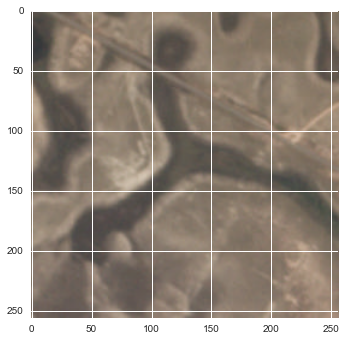

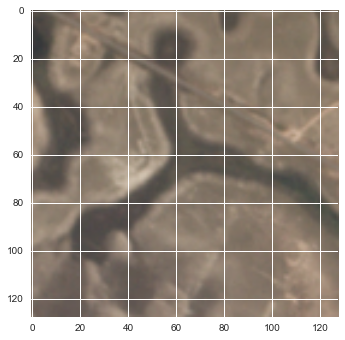

In [83]:
sample_image = io.imread(os.path.join(train_jpg_path, labels_images['bare_ground'][20]) + '.jpg')
sample_image_resize = resize(sample_image, (128, 128))
plt.imshow(sample_image)
plt.show()
plt.imshow(sample_image_resize)
plt.show()

# 2. Look in details about the tags

In [4]:
print(train_df.tags.value_counts().head(20))

print('count of different tags: {}'.format(len(train_df.tags.unique())))

clear primary                                            13636
partly_cloudy primary                                     3630
cloudy                                                    2089
clear primary water                                       1850
agriculture clear primary road                            1680
agriculture clear primary                                 1626
haze primary                                              1471
agriculture clear cultivation primary                     1170
agriculture clear habitation primary road                 1125
agriculture clear primary water                            712
agriculture partly_cloudy primary                          692
partly_cloudy primary water                                595
agriculture partly_cloudy primary road                     527
clear primary road water                                   504
clear cultivation primary                                  472
agriculture clear primary road water                   

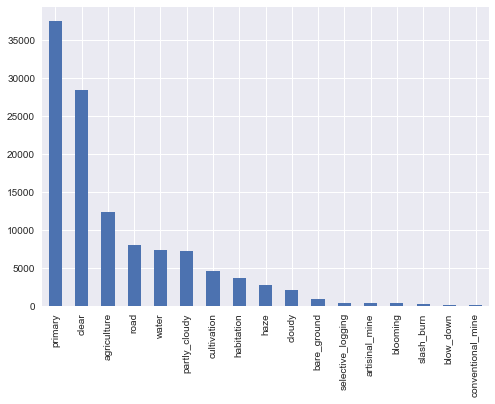

In [5]:
tags = train_df.tags.apply(lambda x: x.split(' '))
labels = {}
for item in tags:
    for label in item:
        if label not in labels:
            labels[label] = 1
        else:
            labels[label] += 1
labels = pd.Series(labels).sort_values(ascending=False)
labels.plot.bar()
plt.show()

# 3. Image processing

### 3.1 Color Correction

In [70]:
jpg_list = os.listdir(train_jpg_path)[:20000]
train_tif_path = r'..\data\processed\train-tif-v2' 
tif_list = os.listdir(train_tif_path)
np.random.shuffle(jpg_list)
jpg_list = jpg_list[:200]

In [71]:
ref_colors = [[],[],[]]
for _file in jpg_list:
    # keep only the first 3 bands, RGB
    _img = io.imread(os.path.join(train_jpg_path, _file))[:,:,:3]
    # Flatten 2-D to 1-D
    _data = _img[:, :, [2,1,0]].reshape((-1,3))
    # Dump pixel values to aggregation buckets
    for i in range(3): 
        ref_colors[i] = ref_colors[i] + _data[:,i].tolist()
    
ref_colors = np.array(ref_colors)

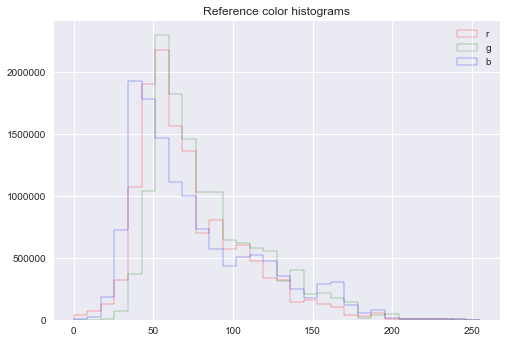

In [72]:
for i,color in enumerate(['r','g','b']):
    plt.hist(ref_colors[i], bins=30, range=[0,255], label=color, color=color, histtype='step')
plt.legend()
plt.title('Reference color histograms')
plt.show()

In [73]:
ref_means = [np.mean(ref_colors[i]) for i in range(3)]
ref_stds = [np.std(ref_colors[i]) for i in range(3)]

In [74]:
def calibrate_image(rgb_image, ref_means, ref_stds):
    # Transform test image to 32-bit floats to avoid 
    # surprises when doing arithmetic with it 
    calibrated_img = rgb_image.copy().astype('float32')

    # Loop over RGB
    for i in range(3):
        # Subtract mean 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]-np.mean(calibrated_img[:,:,i])
        # Normalize variance
        calibrated_img[:,:,i] = calibrated_img[:,:,i]/np.std(calibrated_img[:,:,i])
        # Scale to reference 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]*ref_stds[i] + ref_means[i]
        # Clip any values going out of the valid range
        calibrated_img[:,:,i] = np.clip(calibrated_img[:,:,i],0,255)

    # Convert to 8-bit unsigned int
    return calibrated_img.astype('uint8')

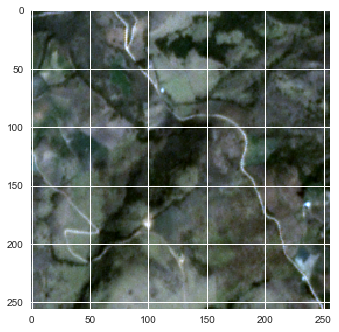

In [89]:
bgrn_image = io.imread(os.path.join(train_tif_path, 'train_301.tif'))
rgb_image = bgrn_image[:, :, [2,1,0]]
plt.imshow(calibrate_image(rgb_image, ref_means, ref_stds))
plt.show()

In [91]:
bgrn_image.shape

(256, 256, 4)

### 3.2 rotate/flip image

In [92]:
from scipy import ndimage

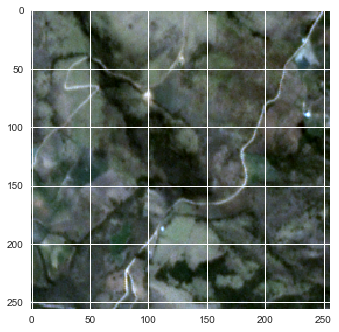

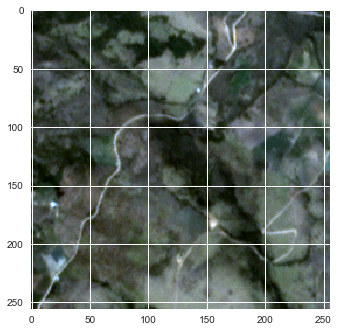

In [95]:
bgrn_image_flipud = np.flipud(bgrn_image)

plt.imshow(calibrate_image(bgrn_image_flipud[:, :, [2, 1, 0]], ref_means, ref_stds))
plt.show()

bgrn_image_fliplr = np.fliplr(bgrn_image)
plt.imshow(calibrate_image(bgrn_image_fliplr[:, :, [2, 1, 0]], ref_means, ref_stds))
plt.show()

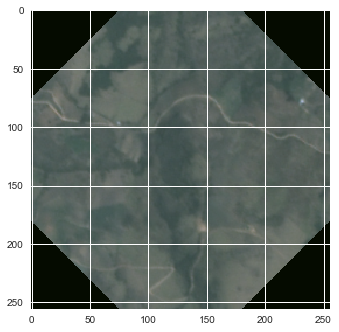

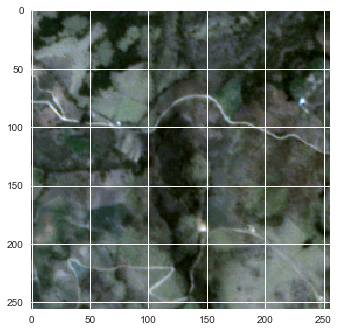

In [106]:
bgrn_roatate = ndimage.rotate(bgrn_image, 45, reshape=False)
plt.imshow(calibrate_image(bgrn_roatate[:, :, [2, 1, 0]], ref_means, ref_stds))
plt.show()

bgrn_roatate = ndimage.rotate(bgrn_image, 45, reshape=False, mode='reflect')
plt.imshow(calibrate_image(bgrn_roatate[:, :, [2, 1, 0]], ref_means, ref_stds))
plt.show()